# A/B test peaking and plotting progress

In [70]:
import pandas as pd
from comfy_bayes.bayes_conversion import ConversionTest

In [71]:
import matplotlib.pyplot as plt

In [72]:
%matplotlib inline

plt.rcParams['figure.figsize'] = (20, 10)

In [73]:
df = (
    pd.read_csv("DATA/dataset.csv")
    .assign(timestamp=lambda df: pd.to_datetime(df["timestamp"])) # should be faster than csv parsing
    .set_index("timestamp") # indexing
    .sort_index() # sorting makes everything easier
)


In [77]:
# extend dataframe each our and calculate A/B test, append results to [stats list]
stats = []
time_points = pd.date_range(df.index.min(), df.index.max(), freq="1H")[10:]

for d in time_points:
    ab_test = ConversionTest.from_pandas(df.loc[:d, :])
    stats.append(ab_test.get_stats())

In [78]:
# this is how our a/b test stats look like each hour
test_results_df = pd.DataFrame(index=time_points, data=stats)
test_results_df.head(6)

,b_better_than_a,conversion_a,conversion_b,hdi_95_lower_a,hdi_95_lower_b,hdi_95_upper_a,hdi_95_upper_b,loss,uplift
2019-04-09 23:19:05,0.705884,0.016484,0.022222,0.007744,0.011462,0.035434,0.043197,0.001995,0.007731
2019-04-10 00:19:05,0.713872,0.015190,0.020725,0.007136,0.010688,0.032685,0.040324,0.001782,0.007346
2019-04-10 01:19:05,0.793363,0.014019,0.021687,0.006585,0.011586,0.030192,0.040671,0.001114,0.008816
2019-04-10 02:19:05,0.863429,0.013015,0.022936,0.006113,0.012631,0.028052,0.041680,0.000641,0.010637
2019-04-10 03:19:05,0.885095,0.014199,0.025105,0.007017,0.014528,0.028977,0.043352,0.000520,0.011442
2019-04-10 04:19:05,0.883284,0.013384,0.023576,0.006614,0.013641,0.027330,0.040740,0.000499,0.010701


#### And now some plots

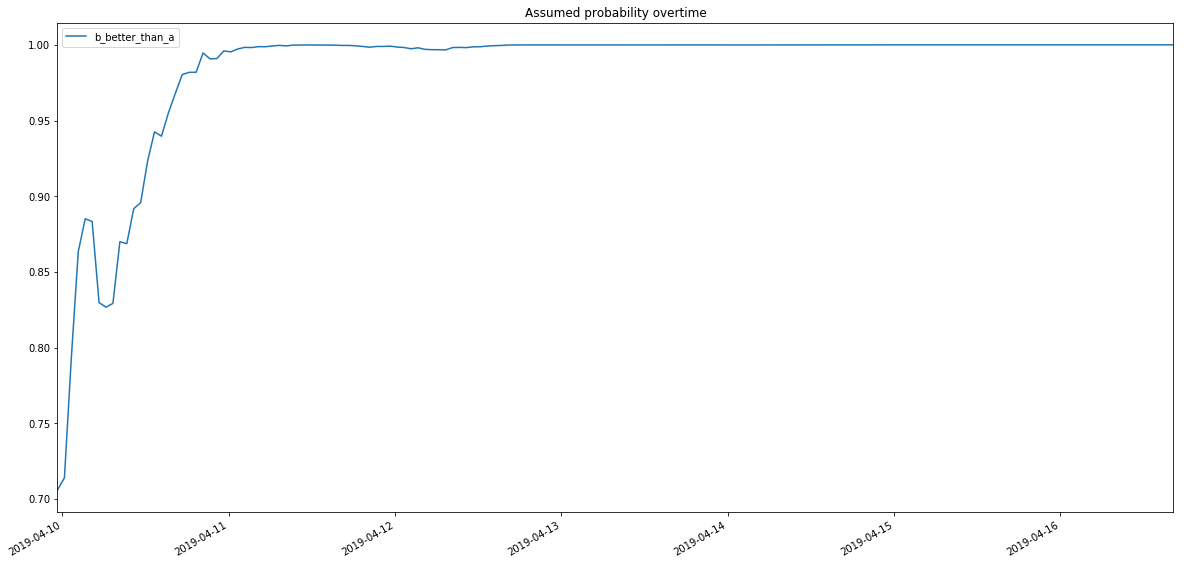

In [85]:
test_results_df[["b_better_than_a"]].plot(title="Assumed probability overtime");

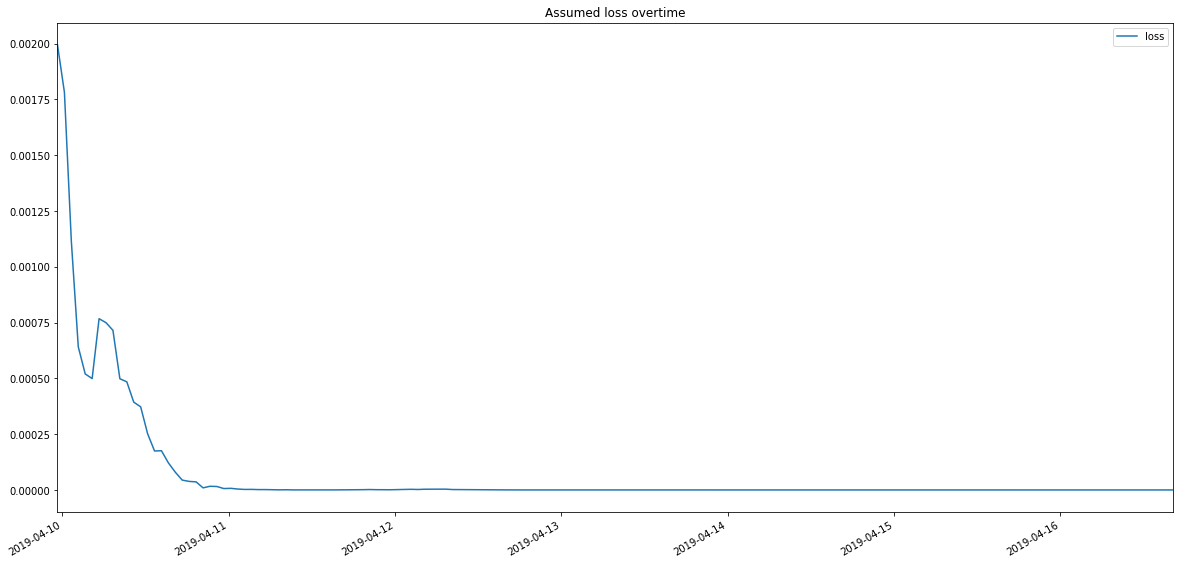

In [84]:
test_results_df[["loss"]].plot.line(title="Assumed loss overtime");

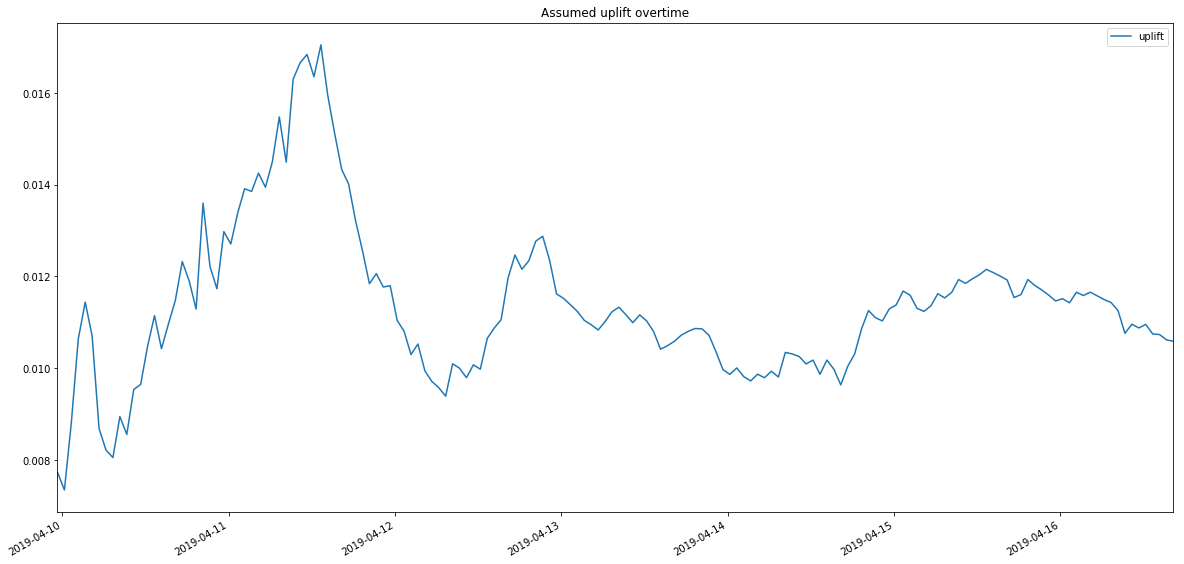

In [83]:
test_results_df[["uplift"]].plot.line(title="Assumed uplift overtime");

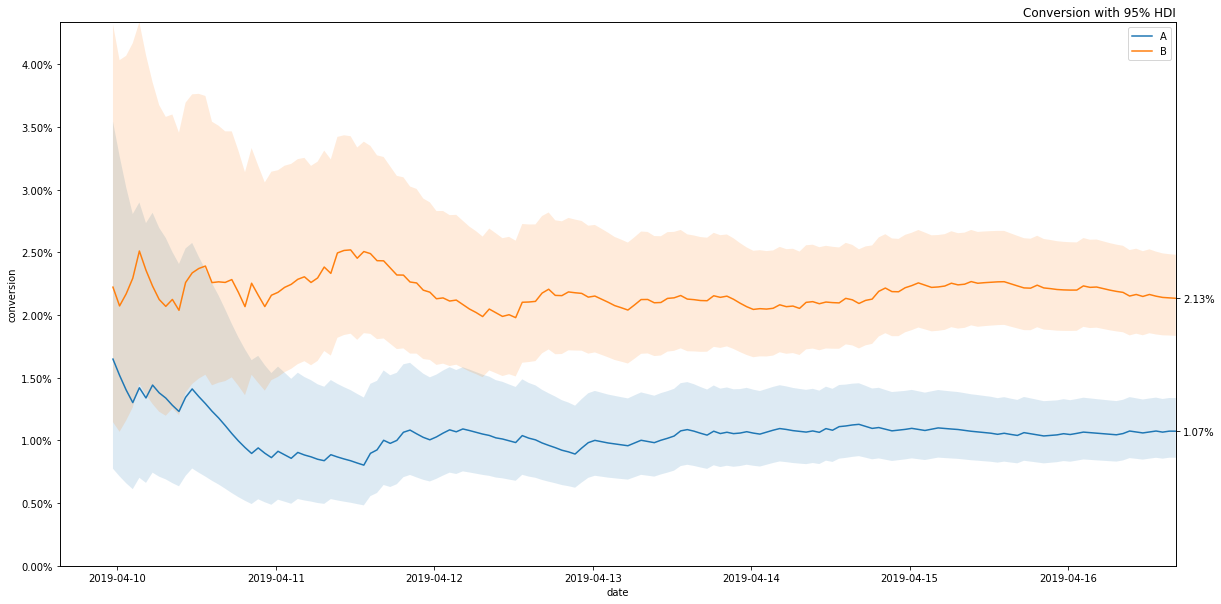

In [89]:
fig, ax = plt.subplots(1, 1)

# conversion lines
ax.plot(test_results_df["conversion_a"], label="A");
ax.plot(test_results_df["conversion_b"], label="B");

x = test_results_df.index.values

# # 95% HDI
ax.fill_between(x, test_results_df['hdi_95_lower_a'], test_results_df['hdi_95_upper_a'], alpha=.15);
ax.fill_between(x, test_results_df['hdi_95_lower_b'], test_results_df['hdi_95_upper_b'], alpha=.15);

# # lims for clearer position of chart values
ax.set_ylim(0, max(test_results_df['hdi_95_upper_a'].max(), test_results_df['hdi_95_upper_b'].max()));
ax.set_xlim(None, x[-1]);

# # labels
ax.set_xlabel("date")
ax.set_ylabel("conversion");
ax.set_title("Conversion with 95% HDI", loc="right");
ax.legend();
ax.set_yticklabels(["{:,.2%}".format(tick) for tick in ax.get_yticks()]);

# second ax as final conversion values
last_values = (test_results_df["conversion_a"][-1], test_results_df["conversion_b"][-1])

ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(last_values)
ax2.set_yticklabels(["{:,.2%}".format(i) for i in last_values]);
ax2.grid(False);